In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:
signal_data = pd.read_hdf('/dice/projects/CMS/Hinv/datasets_for_ml_training/ttH/df_ml_inputs.hd5')
background_data = pd.read_hdf('/dice/projects/CMS/Hinv/datasets_for_ml_training/ttBar/df_ml_inputs.hd5')
#background_data = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/ZH_HToBB_ZToNuNu_M-125.parquet')
#background_data = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTToSemiLeptonic.parquet')

In [26]:
print(signal_data.columns)
print(background_data.columns)

print(len(signal_data))
print(len(background_data))

Index(['dataset', 'entry', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_phi', 'InputMet_pt', 'MHT_phi', 'MHT_pt', 'MinChi',
       'MinOmegaHat', 'MinOmegaTilde', 'Pred', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_eta', 'cleanedJet_mass',
       'cleanedJet_phi', 'cleanedJet_pt', 'hashed_filename', 'ldphi_bjet',
       'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 'region', 'sdphi_bjet',
       'sdphi_jet', 'weight_nominal', 'xs_weight'],
      dtype='object')
Index(['dataset', 'entry', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_phi', 'InputMet_pt', 'MHT_phi', 'MHT_pt', 'MinChi',
       'MinOmegaHat', 'MinOmegaTilde', 'Pred', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_eta', 'cleanedJet_mass',
       'cleanedJet_phi', 'cleanedJet_pt', 'hashed_filename', 'ldphi_bjet',
       'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 'region', 'sdphi_bjet',
       'sdphi_jet', 'weight_nominal', 'xs_weight'],
      dtype='obj

In [27]:
## DATA PREPARATION



def prep(signal_data, background_data):

    #remove NaN values
    signal_data = signal_data.dropna()
    background_data = background_data.dropna()

    #remove unsuitable regions in the regions column (want only 0 and 6+)
    regions_to_exclude = [1,2,3,4,5]
    signal_data = signal_data[~signal_data.region.isin(regions_to_exclude)]
    background_data = background_data[~background_data.region.isin(regions_to_exclude)]
    
    #add balance weights
    # this helps balance the training dataset. Signal data points are given HIGHER weights based on the imbalance
    #weight=1 is the base weight, which we assign to background_data
    # creating new column 'weight_balance' and assigning it to 1 for background_data and len(background_data)/len(signal_data) for signal_data
    signal_data['weight_balance'] = len(background_data) / len(signal_data)
    background_data['weight_balance'] = 1
    #this weight is applied to the loss^ 

    # Label signal and background data
    signal_data['target'] = 1
    background_data['target'] = 0

    #combine sign & BG datasets
    data = pd.concat([signal_data, background_data])



    ###
    # Look into jets, otherwise just delete:

    #add additional columns to the data frame
    # calculating statistical properties of cleanedJet_eta and 
    #cleanedJet_phi, such as standard deviation (std) and range (max-min).
    #New features can be useful for model
    data['cleanedJet_eta_std'] = data['cleanedJet_eta'].apply(lambda x: np.std(x))
    data['cleanedJet_eta_range'] = data['cleanedJet_eta'].apply(lambda x: np.max(x) - np.min(x))
    data['cleanedJet_phi_std'] = data['cleanedJet_phi'].apply(lambda x: np.std(x))
    data['cleanedJet_phi_range'] = data['cleanedJet_phi'].apply(lambda x: np.max(x) - np.min(x))
    ###
    return data

data = prep(signal_data, background_data)


In [28]:
# Define features and scale them
features = [
    'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi', 'InputMet_pt', 'MHT_pt',
    'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_eta_std', 
    'cleanedJet_eta_range', 'cleanedJet_phi_range', 'cleanedJet_phi_std', 
    'ldphi_bjet', 'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 
    'region', 'sdphi_bjet', 'sdphi_jet'
]

#scales features to have a mean = 0  and std = 1 (makes training more stable & efficient).
scaler = StandardScaler()
#Fit the scalar to selected features in data & transform them in place, overwriting opriginal values witht he SCALED ones
data[features] = scaler.fit_transform(data[features])



#we need to scale as some features varyb widely in magnitude which can hinder training.
#NN's are sensitive to the scale of the input data. Scaling ensures all features contribute proportionally to the models training process.


In [29]:
len(features)

19

In [30]:
# Convert data to PyTorch tensors

#Convert features to tensors(x). X is a tensor containing values of selected features from data[features].values
X = torch.tensor(data[features].values, dtype=torch.float32)

# Convert target to tensors(y). y is a tensor of target labels, indicating whether sample is sig (1) or BG (0).as_integer_ratio
# #.view(-1,1) reshapes y into column vector for binary classification.
y = torch.tensor(data['target'].values, dtype=torch.float32).view(-1, 1)

#converting weights to tensors. Used later in training loop to handle class imbalance
weights_nominal = torch.tensor(data['weight_nominal'].values, dtype=torch.float32)
weights_balance = torch.tensor(data['weight_balance'].values, dtype=torch.float32)


In [31]:
# Split data into train, validation, and test sets.
#80/20 train/test split. Outputs represent features labels, nominal weights & balance weights for both..
#.. training & validation set and test set.
X_train_val, X_test, y_train_val, y_test, wn_train_val, wn_test, wb_train_val, wb_test = train_test_split(
    X, y, weights_nominal, weights_balance, test_size=0.2, random_state=42
)
#each x_train val is paired with y_train_val, wn_train_val, wb_train_val. (X_train_val, y_train_val, wn_train_val, wb_train_val)
#each x_test is paired with y_test, wn_test, wb_test. (X_test, y_test, wn_test, wb_test)
# ... allows us to keep track of weights. 

#this splits the training+validation set into   (64%) and validation (16%). These numbers come from 0.8*0.8=0.64, 0.8*0.2=0.16. 
#1st split is training+validation vs test. Second split only on the training+validation. 80% training, 20% validation.
X_train, X_val, y_train, y_val, wn_train, wn_val, wb_train, wb_val = train_test_split(
    X_train_val, y_train_val, wn_train_val, wb_train_val, test_size=0.2, random_state=42
)


#Training set trains model. (Xtrain,yt_train,wn_train,wb_train)
#Validation set evaluates models performance during trainign & adjusts hyperparameters if needed. (X_val,y_val,wn_val,wb_val
#Test set is set aside until end of training to evaluate the model's generalisation ability on completely unseen data. (xtets,ytest,wntest,wbtest)


In [32]:
# Create DataLoaders

#(#Look at gradient descent mini batch)

#DataLoader is a PyTorch class that loads data in batches.
#train_loader loads training data in batches of 64 samples. shuffle=True shuffles the data before each epoch.
train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wb_train), batch_size=64, shuffle=True)

#val_loader loads validation data in batches of 64 samples. shuffle=False as we don't want to shuffle validation data.
val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wb_val), batch_size=64, shuffle=False)

#test_loader loads test data in batches of 64 samples. shuffle=False as we don't want to shuffle test data.
test_loader = DataLoader(TensorDataset(X_test, y_test, wn_test, wb_test), batch_size=64, shuffle=False)

#shuffle is set to True for training data, as we want to shuffle the data before each epoch to prevent the model from learning the order of the data.

In [33]:
#Defining NN model & initialising loss function & optimiser

#nn.Module is a base class for all NN models in PyTorch. Represents a simple feedforward..
#.. NN with customisable layers & neurons, disigned for binary classification.

class SimpleNN(nn.Module):
    # n_layers is the no. of HIDDEN LAYERS and n_neurons is the no. of neurons in each HIDDEN layer.
    def __init__(self, n_layers=3, n_neurons=32):
        #super() is a method that returns a proxy object that delegates method calls to a parent or sibling class of type.
        #Here, super(SimpleNN, self).__init__() initialises the base class (nn.Module) for the SimpleNN class.
        super(SimpleNN, self).__init__()
        #layers ia a listy that temporatily holds each layer of the model as it is created.
        #this allows us to construct the NN architecture in a loop, rather than writing each layer out individually.
        layers = [nn.Linear(len(features), n_neurons), nn.BatchNorm1d(n_neurons)]
        
        #for loop that creates n_layers-1 hidden layers, each with n_neurons neurons.
        for _ in range(n_layers - 1):
            layers += [nn.Linear(n_neurons, n_neurons), nn.BatchNorm1d(n_neurons)]
        #adds the output layer to the model. This is a single neuron, as we are performing binary classification.
        layers.append(nn.Linear(n_neurons, 1))
        #nn.ModuleList(layers) converts the list of layers into a PyTorch ModuleList, which is a container for Module objects.
        self.layers = nn.ModuleList(layers)

    #the forward method defines the forward pass of the NN. It takes an input tensor x and passes it through each layer of the model.
    def forward(self, x):
        for layer in self.layers[:-1]:
            #applies the ReLU activation function to the output of each hidden layer to introduce non-linearity.
            x = torch.relu(layer(x))
        
        #return self.layers[-1](x) applies the output layer to the final hidden layer output, returning the final model output.
        return self.layers[-1](x)
        #x is not a value between 0 and 1, but a value between -inf and inf. This is because the output layer is a single neuron with no activation function.
        #x is a logit
model = SimpleNN()



##### Look at Binary Cross Entropy formula
##### Look at optim.Adam
##### Try different LR (0.001?)

In [34]:
# Define loss function and optimizer

#criterion is the loss function used to train the model. Here, we use Binary Cross-Entropy Loss with logits.
#optimiser is the optimisation algorithm used to update the model weights during training. Here, we use the Adam optimiser.

criterion = nn.BCEWithLogitsLoss(reduction="none")  # With weight balancing
optimizer = optim.Adam(model.parameters(), lr=0.01)

#lr is the learning rate of the optimiser. This is a hyperparameter that controls the step size of the optimiser during training.

In [35]:
# An epoch is a single pass through the entire training dataset.
n_epochs = 40
#train_losses and val_losses are lists that store the training and validation losses for each epoch.
train_losses, val_losses = [], []

# Training phase
for epoch in range(n_epochs):
    #model.train() sets the model to training model, which enables features like dropout and batch normalisation.
    model.train()

    #running_train_loss and running_val_loss are variables that store the cumulative loss for each epoch.
    running_train_loss = 0.0

    #train_loader is an iterable object that returns batches of training data.
    for batch_x, batch_y, _, batch_wb in train_loader:
        #Zero the gradients to prevent them from accumulating.
        optimizer.zero_grad()
        #model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        #calulates the loss between the model outputs and the target labels.
        loss = criterion(outputs, batch_y.view(-1, 1))

        # Multiplies the loss by the balancing wwight (1 for BG and ~6 for sig) to handle class imbalance.
        weighted_loss = (loss * batch_wb).mean()
        #Backpropagates the loss through the model to calculate the gradients.
        weighted_loss.backward()
        #Updates the model weights using the gradients and the optimiser.

        #goes back and adjusts the weights of the model to reduce the loss. MAYBE
        optimizer.step()
        #running_train_loss accumulates the weighted loss for each batch.
        running_train_loss += weighted_loss.item() * batch_x.size(0)

    #train_losses appends the average training loss for the epoch.
    train_losses.append(running_train_loss / len(train_loader.dataset))





    # Validation phase (model doesn't see this)
    
    #model.eval() sets the model to evaluation mode, which disables features like dropout and batch normalisation.
    model.eval()
    #running_val_loss is a variable that stores the cumulative validation loss for each epoch.
    running_val_loss = 0.0
    #torch.no-grad disables gradient calculation, which reduces memory usage and speeds up computation.
    with torch.no_grad():
        #val_loader is an iterable object that returns batches of validation data.
        for batch_x, batch_y, _, batch_wb in val_loader:
            #calculates the validation loss for the model.
            val_loss = criterion(model(batch_x), batch_y.view(-1, 1))
            #Help handle class imbalance.
            weighted_val_loss = (val_loss * batch_wb).mean()
            # accumulates the weighted validation loss for each batch.
            running_val_loss += weighted_val_loss.item() * batch_x.size(0)
    #val_losses appends the average validation loss for the epoch.
    val_losses.append(running_val_loss / len(val_loader.dataset))

#Prints the training and validation losses for each epoch.
    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')


Epoch [1/40], Training Loss: 0.7243, Validation Loss: 0.7116
Epoch [2/40], Training Loss: 0.7064, Validation Loss: 0.6973
Epoch [3/40], Training Loss: 0.7023, Validation Loss: 0.6995
Epoch [4/40], Training Loss: 0.7010, Validation Loss: 0.6944
Epoch [5/40], Training Loss: 0.6988, Validation Loss: 0.6947
Epoch [6/40], Training Loss: 0.6967, Validation Loss: 0.6940
Epoch [7/40], Training Loss: 0.6961, Validation Loss: 0.6911
Epoch [8/40], Training Loss: 0.6955, Validation Loss: 0.6913
Epoch [9/40], Training Loss: 0.6939, Validation Loss: 0.6923
Epoch [10/40], Training Loss: 0.6933, Validation Loss: 0.6923
Epoch [11/40], Training Loss: 0.6934, Validation Loss: 0.6893
Epoch [12/40], Training Loss: 0.6923, Validation Loss: 0.6898
Epoch [13/40], Training Loss: 0.6920, Validation Loss: 0.6891
Epoch [14/40], Training Loss: 0.6926, Validation Loss: 0.6911
Epoch [15/40], Training Loss: 0.6913, Validation Loss: 0.6918
Epoch [16/40], Training Loss: 0.6909, Validation Loss: 0.6876
Epoch [17/40], Tr

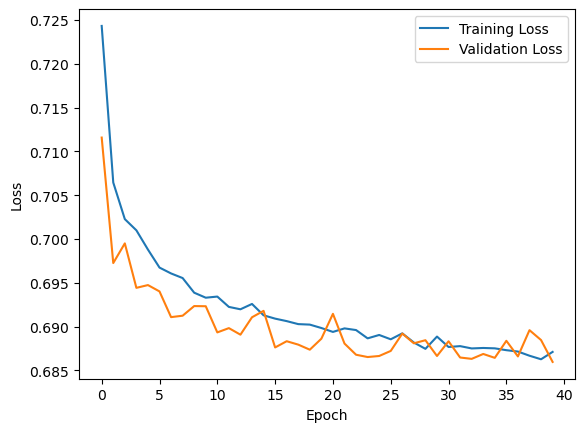

In [36]:
# Plot training and validation losses
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


    

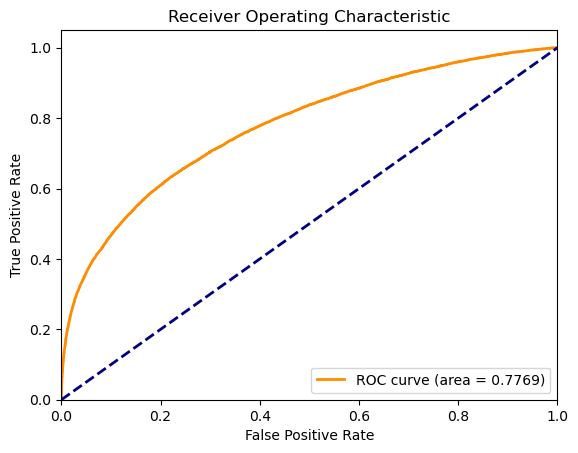

In [37]:
from sklearn.metrics import roc_curve, auc

# Evaluate the model on the test set
model.eval()
y_test_pred = []
with torch.no_grad():
    for batch_x, _, _, _ in test_loader:
        outputs = model(batch_x)
        y_test_pred.append(outputs)

# Concatenate all predictions
y_test_pred = torch.cat(y_test_pred).cpu().numpy()
y_test_true = y_test.cpu().numpy()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Plot Histograms For Model Output

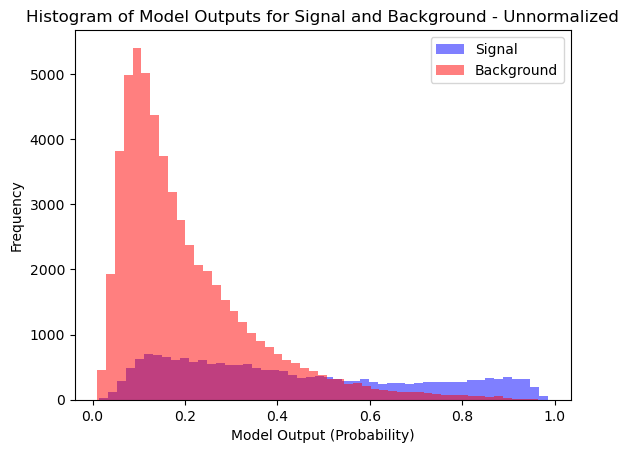

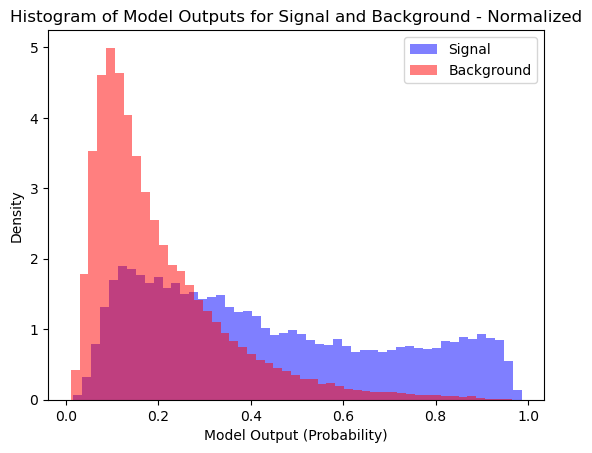

In [38]:
# Apply sigmoid function to model outputs to get probabilities
signal_probs = torch.sigmoid(torch.tensor(y_test_pred[y_test_true == 1])).numpy()
background_probs = torch.sigmoid(torch.tensor(y_test_pred[y_test_true == 0])).numpy()

# Plot histograms
plt.hist(signal_probs, bins=50, alpha=0.5, label='Signal', color='blue')
plt.hist(background_probs, bins=50, alpha=0.5, label='Background', color='red')
plt.xlabel('Model Output (Probability)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Model Outputs for Signal and Background - Unnormalized')
plt.show()

# Plot normalized histograms
plt.hist(signal_probs, bins=50, alpha=0.5, label='Signal', color='blue', density=True)
plt.hist(background_probs, bins=50, alpha=0.5, label='Background', color='red', density=True)
plt.xlabel('Model Output (Probability)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.title('Histogram of Model Outputs for Signal and Background - Normalized')
plt.show()

## Flatten by including jets
### mlp needs same input per event. zero padding to just give zeros. Start by giving just first few jets.

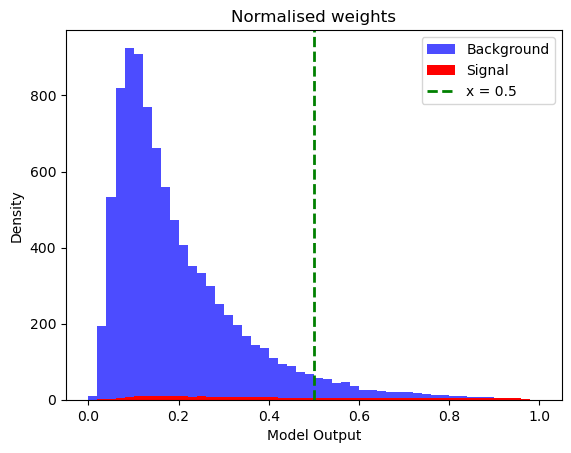

In [39]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), label='Signal',  weights=wn_test[all_labels == 1]*200000, color='r')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()



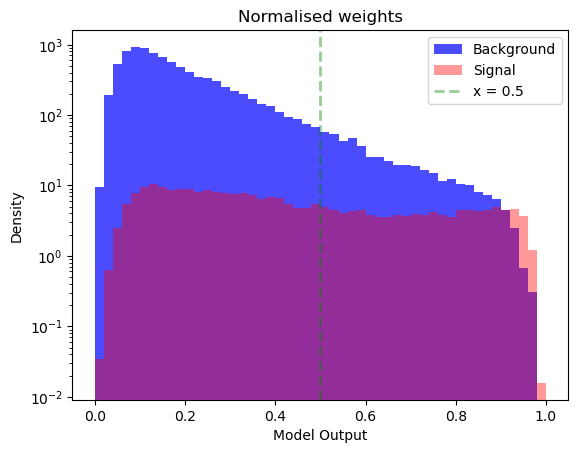

In [40]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), label='Signal',  weights=wn_test[all_labels == 1]*200000, color='r', alpha=0.4)
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5',alpha=0.4)
plt.xlabel('Model Output')
plt.yscale('log')

plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()



Instead of Z = S/sqrt(B),

Z = s/sqrt(B + sigma_b^2)  
where B is the background, S is the signal, and sigma_b is the uncertainty in the background.

Curve may peak in different place and curve will generally go down.

/tmp/ipykernel_1524759/3328139391.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wn_test_array = np.array(wn_test*200000)


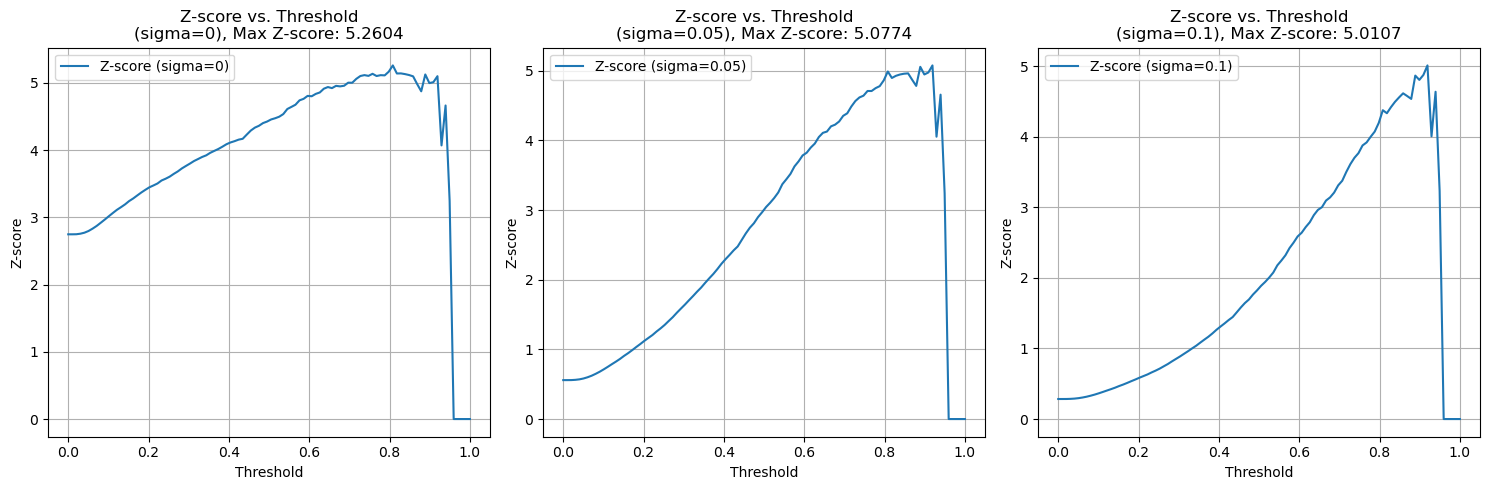

In [41]:
#define uncertainty
sigma_values = [0,0.05,0.1]

# Assume wn_test is the array of weights for each sample in the test set 
wn_test_array = np.array(wn_test*200000)

# Define thresholds between 0 and 1
thresholds = np.linspace(0, 1, 100)
fig, axes = plt.subplots(1, len(sigma_values), figsize=(15, 5))





# Calculate the Z-score for each threshold using weights

for i, sigma in enumerate(sigma_values):
    z_scores = []
    for threshold in thresholds:
        # Weighted count of signal predictions above the threshold
        S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])  # Weighted Signal
        B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])  # Weighted Background

        # Calculate Z-score (add small epsilon to avoid division by zero)
        if S > 2:
            Z = S / np.sqrt(B + (sigma*B)**2 +1e-10)  # 1e-10 to avoid division by zero
        else:
            Z = 0  # Define Z as 0 if S + B is 0
        z_scores.append(Z)

    # Plot Z-score vs. Threshold for the current sigma
    axes[i].plot(thresholds, z_scores, label=f"Z-score (sigma={sigma})")
    axes[i].set_xlabel("Threshold")
    axes[i].set_ylabel("Z-score")
    axes[i].set_title(f"Z-score vs. Threshold\n(sigma={sigma}), Max Z-score: {max(z_scores):.4f}")
    axes[i].legend()
    axes[i].grid()


plt.tight_layout()
plt.show()

In [42]:
# Extract the Z-scores within the specified range
z_scores = np.array(z_scores)

# Find the maximum Z-score and its index within the specified range
max_z_index = np.argmax(z_scores)
max_z = z_scores[max_z_index]

# Find the corresponding threshold
threshold_at_max_z = thresholds[max_z_index]

#calculate associated S and B values at threshold of max z score
S_at_max_z = np.sum(wn_test_array[(all_outputs > threshold_at_max_z) & (all_labels == 1)])  # Weighted Signal
B_at_max_z = np.sum(wn_test_array[(all_outputs > threshold_at_max_z) & (all_labels == 0)])  # Weighted Background

# Calculate the associated S and B values
S = np.sum(wn_test_array[(all_outputs > threshold_at_max_z) & (all_labels == 1)])  # Weighted Signal
B = np.sum(wn_test_array[(all_outputs > threshold_at_max_z) & (all_labels == 0)])  # Weighted Background

print(f"Maximum Z-score: {max_z:.4f}")
print(f"Associated S value: {S_at_max_z:.4f}")
print(f"Associated B value: {B_at_max_z:.4f}")

Maximum Z-score: 5.0107
Associated S value: 9.6868
Associated B value: 3.6073


Maximum Z-score: 5.3088
Associated S value: 39.1373
Associated B value: 54.3452


In [43]:
print(len(wn_test_array))

75627


In [44]:
#incorporate a second background, not just ttbar, e.g. Z->vv, ZJetsToNuNu_HT-*

3 curves of different sigma_b on same canvas, making assumptions for size of syst. uncdertainty affects Z cut point.

# Parquet Data - TTbar to Semi-leptonic

In [45]:
test = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/ZJetsToNuNu_HT-2500ToInf.parquet')

In [46]:
test

,event,region,Generator_weight,Generator_scalePDF,Generator_x1,Generator_x2,Generator_xpdf1,Generator_xpdf2,cleanedJet_pt,cleanedJet_eta,...,cleanedJet_pt_jesAbsolute_2018_up,cleanedJet_pt_jesAbsolute_2018_down,cleanedJet_pt_jesBBEC1_2018_up,cleanedJet_pt_jesBBEC1_2018_down,cleanedJet_pt_jesEC2_2018_up,cleanedJet_pt_jesEC2_2018_down,cleanedJet_pt_jesHF_2018_up,cleanedJet_pt_jesHF_2018_down,cleanedJet_pt_jesRelativeSample_2018_up,cleanedJet_pt_jesRelativeSample_2018_down
0,164284,0,1.0,1487.0000,0.246056,0.474136,0.0,0.0,"[1439.7167, 1235.8717, 127.51087, 99.083244, 8...","[-1.1123047, 0.40429688, -1.0380859, 0.6962890...",...,"[1444.3461, 1239.8151, 127.99279, 99.51354, 88...","[1435.0872, 1231.9282, 127.02895, 98.65295, 87...","[1439.7167, 1235.8717, 127.51087, 99.083244, 8...","[1439.7167, 1235.8717, 127.51087, 99.083244, 8...","[1439.7167, 1235.8717, 127.51087, 99.083244, 8...","[1439.7167, 1235.8717, 127.51087, 99.083244, 8...","[1439.7167, 1235.8717, 127.51087, 99.083244, 8...","[1439.7167, 1235.8717, 127.51087, 99.083244, 8...","[1442.8518, 1235.3658, 126.27212, 98.77752, 85...","[1436.5814, 1236.3774, 128.74962, 99.38897, 89..."
1,164353,6,1.0,1451.0000,0.509125,0.222847,0.0,0.0,"[1459.4486, 1052.9186, 255.02821, 147.05795, 3...","[-0.041015625, 0.54833984, 0.5908203, 1.699218...",...,"[1464.1576, 1056.1826, 255.89871, 147.72568, 3...","[1454.7395, 1049.6544, 254.1577, 146.39021, 37...","[1459.4486, 1052.9186, 255.02821, 147.54616, 3...","[1459.4486, 1052.9186, 255.02821, 146.56975, 3...","[1459.4486, 1052.9186, 255.02821, 147.05795, 3...","[1459.4486, 1052.9186, 255.02821, 147.05795, 3...","[1459.4486, 1052.9186, 255.02821, 147.05795, 3...","[1459.4486, 1052.9186, 255.02821, 147.05795, 3...","[1463.4279, 1052.3534, 254.56575, 144.1871, 37...","[1455.4692, 1053.4836, 255.49066, 149.92879, 3..."
2,164680,6,1.0,1294.5000,0.210350,0.313675,0.0,0.0,"[1409.3743, 1199.9999, 82.16708, 76.92712, 35....","[-0.29174805, 0.25585938, -1.0146484, -0.07019...",...,"[1414.023, 1203.7996, 82.52409, 77.29796, 36.1...","[1404.7256, 1196.2002, 81.810074, 76.55627, 35...","[1409.3743, 1199.9999, 82.16708, 76.92712, 35....","[1409.3743, 1199.9999, 82.16708, 76.92712, 35....","[1409.3743, 1199.9999, 82.16708, 76.92712, 35....","[1409.3743, 1199.9999, 82.16708, 76.92712, 35....","[1409.3743, 1199.9999, 82.16708, 76.92712, 35....","[1409.3743, 1199.9999, 82.16708, 76.92712, 35....","[1408.9491, 1199.4796, 81.14988, 76.70693, 35....","[1409.7993, 1200.5201, 83.18429, 77.14729, 36...."
3,165092,0,1.0,964.9375,0.370514,0.283218,0.0,0.0,"[670.4296, 601.27936, 506.31866, 228.4473, 52....","[0.6347656, 1.1855469, -0.50634766, 1.1621094,...",...,"[672.48663, 603.023, 507.86462, 229.16304, 53....","[668.37256, 599.53564, 504.77274, 227.73155, 5...","[670.4296, 601.27936, 506.31866, 228.4473, 53....","[670.4296, 601.27936, 506.31866, 228.4473, 52....","[670.4296, 601.27936, 506.31866, 228.4473, 52....","[670.4296, 601.27936, 506.31866, 228.4473, 52....","[670.4296, 601.27936, 506.31866, 228.4473, 52....","[670.4296, 601.27936, 506.31866, 228.4473, 52....","[669.8688, 600.32025, 505.73474, 226.9854, 51....","[670.9904, 602.2384, 506.90262, 229.90918, 53...."
4,166288,0,1.0,3323.1250,0.802277,0.192093,0.0,0.0,"[1484.8162, 1104.6554, 170.91957, 145.60504, 4...","[0.45117188, -0.032989502, 0.06304932, 0.68994...",...,"[1489.7767, 1108.0819, 171.56317, 146.17105, 4...","[1479.8557, 1101.229, 170.27597, 145.03903, 48...","[1484.8162, 1104.6554, 170.91957, 145.60504, 4...","[1484.8162, 1104.6554, 170.91957, 145.60504, 4...","[1484.8162, 1104.6554, 170.91957, 145.60504, 5...","[1484.8162, 1104.6554, 170.91957, 145.60504, 4...","[1484.8162, 1104.6554, 170.91957, 145.60504, 4...","[1484.8162, 1104.6554, 170.91957, 145.60504, 4...","[1484.4314, 1107.2001, 170.73216, 145.23016, 4...","[1485.201, 1102.1107, 171.10698, 145.97992, 50..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10626,4138267,0,1.0,1882.6875,0.142639,0.52